# Most Valuable Customers
 
 ## Background
 The (hypothetical) company in which I work as a senior data analyst, Summit Outfitters, has recently secured a substantial round of investment to expand its market presence both online and in flagship stores located in prime outdoor destinations. Summit Outfitters is known for its premium gear catering to outdoor enthusiasts, including climbers, hikers, skiers, and trail runners. 
 
 The company has maintained steady growth through a loyal customer base and strong brand reputation. Now, under the strategic guidance of our visionary CEO, Alex Rivera, Summit Outfitters is ready to leverage its current momentum and tap into broader markets. Alex believes that a deep understanding of the company's current customer base will allow us to refine our marketing efforts, enhance product offerings, and increase sales efficiency, leading us to new heights of success. 

 Alex Rivera approached me with a strategic request from the recent investment round. The investors are interested in maximizing returns by enhancing the efficiency of marketing spend and increasing the average customer lifetime value. They want to focus on two key areas:
 - Identifying the most valuable customers from the existing customer base. What makes these customers valuable? The goal is to understand what makes these customers valuable, whether it's through their purchasing patterns, loyalty, or average transaction value. This understanding will help in tailoring marketing campaigns and loyalty programs that effectively target and retain these segments.
 - Exploring cross-selling and up-selling opportunities. With a diverse range of products, from technical climbing gear to premium outdoor apparel, Alex believes there is untapped potential in cross-selling and upselling. He wants you to use the customer transaction data to identify opportunities where customers purchasing certain items might be interested in others. For example, customers buying high-end skis might be potential targets for premium ski wear or exclusive ski accessories.

Alex expects a comprehensive report that not only identifies key customer segments and outlines potential cross-sell and upsell strategies but also provides actionable insights and practical recommendations for targeted marketing initiatives. The focus is on enhancing customer experience and maximizing revenue per customer, and my expertise will play a significant part in achieving these goals.

## Approach
To address Alex Rivera's strategic request, I will follow a structured approach that involves the following key steps:
1. Understand the problem, including the definitions of individual words/concepts.
2. Determine a minimum viable answer that we can use to make a decision and prompt further questions.
3. Identify any additional information that would be helpful (data, people, etc.) to have to get the minimum viable answer.
4. Obtain the data. 
5. Plan and execute the work required to get the minimum viable answer.
6. Review the results and determine if we need to do more work.
7. Iterate as needed.

### Understand
- **Most Valuable Customers**: These are customers who contribute significantly to the company's revenue and profitability. They may exhibit high purchase frequency, high average transaction value, or long-term loyalty.
- **Cross-Selling**: This involves selling additional products or services to an existing customer. The goal is to increase the customer's value by offering complementary or related items.
- **Up-Selling**: This involves persuading a customer to buy a more expensive version of a product or to add features or upgrades. The goal is to increase the customer's spending per transaction.

### Minimum Viable Answers
1. Who are our most valuable customers?
2. In which customer segments can we leverage cross-selling and up-selling opportunities?

### Data
*This data comes from the publicly-avaiable [Online Retail Customer Churn Dataset](https://www.kaggle.com/datasets/hassaneskikri/online-retail-customer-churn-dataset) on Kaggle. For the sake of this case study, let's pretend that it came from our company's data lake.*

I ran the following query on our company's data lake to pull the relevant data:
```sql
with customer_bio as (
        select Customer_ID
        , Age
        , Gender
        , Annual_Income 
        from customers c)
    , customer_activity as (
        select sum(Purchase_Amt) over (partition by Customer_ID) as Total_Spend
        , date_diff(max(date(Timestamp)), min(date(Timestamp)), year) as Years_as_Customer
        , count(*) over (partition by Customer_ID) as Num_of_Purchases
        , avg(purchase_amt) over (partition by Customer_ID) as Average_Transaction_Amount
        , sum(Return_Amt) over (partition by Customer_ID) as Num_of_Returns
        , date_diff(current_date(), max(date(Timestamp)) over (partition by Customer_ID), day) as Last_Purchase_Days_Ago 
        from purchases p)
select cb.Customer_ID
    , cb.Age
    , cb.Gender
    , cb.Annual_Income
    , ca.Total_Spend
    , ca.Years_as_Customer
    , ca.Num_of_Purchases
    , ca.Average_Transaction_Amount
    , ca.Num_of_Returns
    , ca.Last_Purchase_Days_Ago
from customer_bio cb join customer_activity ca on cb.Customer_ID = ca.Customer_ID
limit 1000;
```
to get the following columns: 
- Customer_ID
- Age
- Gender
- Annual_Income
- Total_Spend
- Years_as_Customer
- Num_of_Purchases
- Average_Transaction_Amount
- Num_of_Returns
- Last_Purchase_Days_Ago

### Do the Work

In [162]:
import pandas as pd
df = pd.read_csv("../data/online_retail_customer_churn.csv", 
                 usecols=["Customer_ID", "Age", "Gender", "Annual_Income", "Total_Spend", "Years_as_Customer", 
                          "Num_of_Purchases", "Average_Transaction_Amount", "Num_of_Returns", "Last_Purchase_Days_Ago"],
                 index_col="Customer_ID")

In [163]:
df.head()

Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
Customer_ID                                                              
1             62  Other          45.15      5892.58                  5   
2             65   Male          79.51      9025.47                 13   
3             18   Male          29.19       618.83                 13   
4             21  Other          79.63      9110.30                  3   
5             21  Other          77.66      5390.88                 15   

             Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
Customer_ID                                                                 
1                          22                      453.80               2   
2                          77                       22.90               2   
3                          71                       50.53               5   
4                          33                      411.83               5   
5                          43                      101.19               3   

             Last_Purchase_Days_Ago  
Customer_ID                          
1                               129  
2                               227  
3                               283  
4                               226  
5                               242

In [164]:
# Let's check whether there are any missing values in the dataset
df.isnull().sum()

Age                           0
Gender                        0
Annual_Income                 0
Total_Spend                   0
Years_as_Customer             0
Num_of_Purchases              0
Average_Transaction_Amount    0
Num_of_Returns                0
Last_Purchase_Days_Ago        0
dtype: int64

In [165]:
# Let me step out of this case study for a moment. I have rarely seen a dataset with no missing values. Let's make this more realistic.
import numpy as np

# Determine the number of values to replace with missing values: 1.5% of the dataset
n_missing = int(df.size * 0.025)

# Create a Boolean mask of the same shape as the dataframe, with n_missing elements set to True
mask = np.random.choice([True, False], size=df.shape, p=[0.015, 0.985])

# Apply the mask to the dataframe
df = df.mask(mask)

#### Cleaning and Exploring the Data
Let's start by exploring the data's structure and contents. Let's check for missing values, outliers and any other data quality issues that need to be addressed.

In [166]:
# Check import dtypes and convert them to the best possible dtypes. This is a small dataset, but it's a good practice to do this anyway.
print(f"Old dtypes:\n{df.dtypes}")
df = df.convert_dtypes()
print(f"New dtypes:\n{df.dtypes}")

Old dtypes:
Age                           float64
Gender                         object
Annual_Income                 float64
Total_Spend                   float64
Years_as_Customer             float64
Num_of_Purchases              float64
Average_Transaction_Amount    float64
Num_of_Returns                float64
Last_Purchase_Days_Ago        float64
dtype: object
New dtypes:
Age                                    Int64
Gender                        string[python]
Annual_Income                        Float64
Total_Spend                          Float64
Years_as_Customer                      Int64
Num_of_Purchases                       Int64
Average_Transaction_Amount           Float64
Num_of_Returns                         Int64
Last_Purchase_Days_Ago                 Int64
dtype: object


In [167]:
df.info()
print(f"\nThe DataFrame is {df.shape[0]} samples long.")

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         989 non-null    Int64  
 1   Gender                      986 non-null    string 
 2   Annual_Income               985 non-null    Float64
 3   Total_Spend                 986 non-null    Float64
 4   Years_as_Customer           990 non-null    Int64  
 5   Num_of_Purchases            982 non-null    Int64  
 6   Average_Transaction_Amount  985 non-null    Float64
 7   Num_of_Returns              988 non-null    Int64  
 8   Last_Purchase_Days_Ago      989 non-null    Int64  
dtypes: Float64(3), Int64(5), string(1)
memory usage: 85.9 KB

The DataFrame is 1000 samples long.


In [168]:
df.describe(include="all")

Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count       989.0     986          985.0        986.0              990.0   
unique       <NA>       3           <NA>         <NA>               <NA>   
top          <NA>  Female           <NA>         <NA>               <NA>   
freq         <NA>     335           <NA>         <NA>               <NA>   
mean    43.340748     NaN     111.866802  5074.206957           9.731313   
std     15.260895     NaN      52.597035  2861.593773           5.544428   
min          18.0     NaN          20.01       108.94                1.0   
25%          30.0     NaN          67.95     2677.185                5.0   
50%          44.0     NaN          113.6     4980.655                9.0   
75%          56.0     NaN         158.41    7604.9075               14.0   
max          69.0     NaN         199.73      9999.49               19.0   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count              982.0                       985.0           988.0   
unique              <NA>                        <NA>            <NA>   
top                 <NA>                        <NA>            <NA>   
freq                <NA>                        <NA>            <NA>   
mean           49.678208                  267.235503        4.629555   
std            28.592827                  146.175955        2.886298   
min                  1.0                       10.46             0.0   
25%                 25.0                      139.06             2.0   
50%                 49.0                      271.31             5.0   
75%                 74.0                      402.65             7.0   
max                 99.0                      499.57             9.0   

        Last_Purchase_Days_Ago  
count                    989.0  
unique                    <NA>  
top                       <NA>  
freq                      <NA>  
mean                182.835187  
std                 104.305066  
min                        1.0  
25%                       93.0  
50%                      180.0  
75%                      274.0  
max                      363.0

In [169]:
# What immediately pops out are the three unique genders. Let's see how those are categorized.
df["Gender"].value_counts()

Gender
Female    335
Male      330
Other     321
Name: count, dtype: Int64

The `Gender`s look valid and evenly-distributed, so we don't need to do sophisticated imputation on that variable.

Looking at the numeric columns, the mean and standard deviation of each column looks very close to the corresponding median and 75th percentile. This gestures towards normality, but the min and max values around around two standard deviations from the mean, so visualizing the distributions will be helpful.

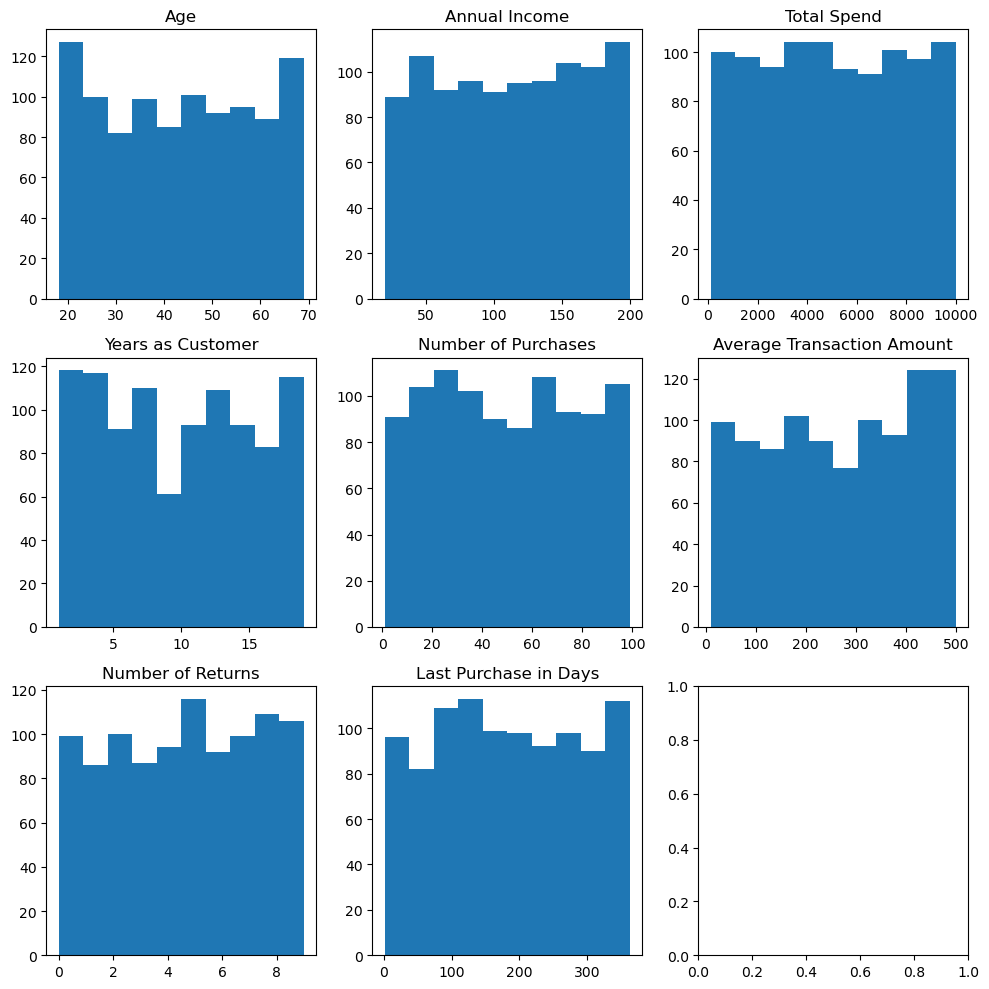

In [170]:

# Let's plot histograms of the numeric columns.
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes[0, 0].hist(df["Age"])
axes[0, 0].set_title("Age")

axes[0, 1].hist(df["Annual_Income"])
axes[0, 1].set_title("Annual Income")

axes[0, 2].hist(df["Total_Spend"])
axes[0, 2].set_title("Total Spend")

axes[1, 0].hist(df["Years_as_Customer"])
axes[1, 0].set_title("Years as Customer")

axes[1, 1].hist(df["Num_of_Purchases"])
axes[1, 1].set_title("Number of Purchases")

axes[1, 2].hist(df["Average_Transaction_Amount"])
axes[1, 2].set_title("Average Transaction Amount")

axes[2, 0].hist(df["Num_of_Returns"])
axes[2, 0].set_title("Number of Returns")

axes[2, 1].hist(df["Last_Purchase_Days_Ago"])
axes[2, 1].set_title("Last Purchase in Days")

plt.tight_layout()
plt.show()

They're all skewed, so we will need to think about our imputation method. We have several options:
- Mean: This is probably not the best choice, as the distributions are skewed. It's trivial to impute and compare the results to the original dataset's summary statistics, but I'm not sure it will be the most accurate.
- Median: This is a better choice for skewed distributions, but it's not perfect. It's also trivial to impute and compare the results to the original dataset's summary statistics.
- Mode: If the datasets exhibited any peakedness, this may be a good choice. In this case, however, it's not appropriate.
- K-means/Multivariate: This is the most sophisticated method, but it's also the most accurate. It's not trivial to implement, but it can be worth the effort.

My instinct is to use the median, as it's the most appropriate for skewed distributions and it's trivial to implement. I'll compare the results of mean and median imputation to the original dataset's summary statistics to see which is the better choice. K-means imputation is attractive, but there are three reasons I'm not going to use it unless absolutely necessary:
1. The number of missing points is extremely low, so inaccurate values should not significantly affect the overall distribution. 
2. This analysis is coming on the heels of a recent investing round. It would be better to get a quick answer and iterate than to spend a lot of time on a sophisticated method that may not be necessary. I would rather spend more time analyzing the results and iterating on the analysis than overinvesting in the imputation method.
3. We will be looking at clusters, so our precision in imputation is less important than it would be in a regression or classification problem.

First, let's fill the `Gender` column, then we'll impute the missing values in the numeric columns.

In [171]:
num_missing = df["Gender"].isnull().sum()
imputed_genders = np.random.choice(["Female", "Male", "Other"], size=num_missing, p=[0.33, 0.33, 0.34])
df.loc[df['Gender'].isnull(), 'Gender'] = imputed_genders

print(df["Gender"].value_counts())
print(f"\n{df["Gender"].isnull().sum()} missing values remain.")

Gender
Female    338
Male      336
Other     326
Name: count, dtype: Int64

0 missing values remain.


In [172]:
# Let's return to the numeric columns and compare mean vs. median imputation.
import pandas as pd
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()


def mean_imputation(df, column_list=None):
    if column_list is None:
        column_list = df.select_dtypes(include=['number']).columns.tolist()

    for column in column_list:
        mean_value = df[column].mean()
        if pd.api.types.is_integer_dtype(df[column].dtype):
            mean_value = round(mean_value)
        df[column] = df[column].fillna(mean_value)
    return df

def median_imputation(df, column_list=None):
    if column_list is None:
        column_list = df.select_dtypes(include=['number']).columns.tolist()

    for column in column_list:
        median_value = df[column].median()
        if pd.api.types.is_integer_dtype(df[column].dtype):
            median_value = round(median_value)
        df[column] = df[column].fillna(median_value)
    return df

df_mean = mean_imputation(df.copy(), numeric_columns)
df_median = median_imputation(df.copy(), numeric_columns)

In [173]:
df.describe(include="all")

Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count       989.0    1000          985.0        986.0              990.0   
unique       <NA>       3           <NA>         <NA>               <NA>   
top          <NA>  Female           <NA>         <NA>               <NA>   
freq         <NA>     338           <NA>         <NA>               <NA>   
mean    43.340748     NaN     111.866802  5074.206957           9.731313   
std     15.260895     NaN      52.597035  2861.593773           5.544428   
min          18.0     NaN          20.01       108.94                1.0   
25%          30.0     NaN          67.95     2677.185                5.0   
50%          44.0     NaN          113.6     4980.655                9.0   
75%          56.0     NaN         158.41    7604.9075               14.0   
max          69.0     NaN         199.73      9999.49               19.0   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count              982.0                       985.0           988.0   
unique              <NA>                        <NA>            <NA>   
top                 <NA>                        <NA>            <NA>   
freq                <NA>                        <NA>            <NA>   
mean           49.678208                  267.235503        4.629555   
std            28.592827                  146.175955        2.886298   
min                  1.0                       10.46             0.0   
25%                 25.0                      139.06             2.0   
50%                 49.0                      271.31             5.0   
75%                 74.0                      402.65             7.0   
max                 99.0                      499.57             9.0   

        Last_Purchase_Days_Ago  
count                    989.0  
unique                    <NA>  
top                       <NA>  
freq                      <NA>  
mean                182.835187  
std                 104.305066  
min                        1.0  
25%                       93.0  
50%                      180.0  
75%                      274.0  
max                      363.0

In [174]:
df_mean.describe(include="all")

Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count      1000.0    1000         1000.0       1000.0             1000.0   
unique       <NA>       3           <NA>         <NA>               <NA>   
top          <NA>  Female           <NA>         <NA>               <NA>   
freq         <NA>     338           <NA>         <NA>               <NA>   
mean       43.337     NaN     111.866802  5074.206957              9.734   
std     15.176685     NaN      52.200669   2841.47182           5.516673   
min          18.0     NaN          20.01       108.94                1.0   
25%          30.0     NaN        68.3425    2698.4825                5.0   
50%          43.0     NaN         112.72     5049.995               10.0   
75%          56.0     NaN        158.025     7592.145               14.0   
max          69.0     NaN         199.73      9999.49               19.0   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count             1000.0                      1000.0          1000.0   
unique              <NA>                        <NA>            <NA>   
top                 <NA>                        <NA>            <NA>   
freq                <NA>                        <NA>            <NA>   
mean              49.684                  267.235503           4.634   
std            28.334095                  145.074388        2.869194   
min                  1.0                       10.46             0.0   
25%                25.75                    141.0275             2.0   
50%                 50.0                  267.235503             5.0   
75%                 74.0                    400.2675             7.0   
max                 99.0                      499.57             9.0   

        Last_Purchase_Days_Ago  
count                   1000.0  
unique                    <NA>  
top                       <NA>  
freq                      <NA>  
mean                   182.837  
std                 103.729225  
min                        1.0  
25%                      93.75  
50%                      182.0  
75%                     272.25  
max                      363.0

In [175]:
df_median.describe(include="all")

Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count      1000.0    1000         1000.0       1000.0             1000.0   
unique       <NA>       3           <NA>         <NA>               <NA>   
top          <NA>  Female           <NA>         <NA>               <NA>   
freq         <NA>     338           <NA>         <NA>               <NA>   
mean       43.348     NaN       111.8928   5072.89723              9.724   
std     15.176799     NaN      52.201095    2841.4931           5.517088   
min          18.0     NaN          20.01       108.94                1.0   
25%          30.0     NaN        68.3425    2698.4825                5.0   
50%          44.0     NaN          113.6     4980.655                9.0   
75%          56.0     NaN        158.025     7592.145               14.0   
max          69.0     NaN         199.73      9999.49               19.0   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count             1000.0                      1000.0          1000.0   
unique              <NA>                        <NA>            <NA>   
top                 <NA>                        <NA>            <NA>   
freq                <NA>                        <NA>            <NA>   
mean              49.666                   267.29662           4.634   
std            28.334207                  145.075234        2.869194   
min                  1.0                       10.46             0.0   
25%                25.75                    141.0275             2.0   
50%                 49.0                      271.31             5.0   
75%                 74.0                    400.2675             7.0   
max                 99.0                      499.57             9.0   

        Last_Purchase_Days_Ago  
count                   1000.0  
unique                    <NA>  
top                       <NA>  
freq                      <NA>  
mean                   182.804  
std                 103.729646  
min                        1.0  
25%                      93.75  
50%                      180.0  
75%                     272.25  
max                      363.0

In [176]:
# Ultimately, they're not that different. Let's go with median imputation since the datasets are skewed.
df = df_median

In [177]:
# Let's check for values with a Z-score higher than 2.
from scipy import stats

def zscore_outliers(df, column_list=None, zscore_threshold=2):
    if column_list is None:
        column_list = df.select_dtypes(include=['number']).columns.tolist()

    zscores = df[column_list].apply(stats.zscore)
    return df[(zscores.abs() > zscore_threshold).any(axis=1)]

outliers = zscore_outliers(df, zscore_threshold=2)
print(f"{outliers.shape[0]} outliers found.")

0 outliers found.


#### Correlation and Feature Engineering
I have some ideas for metrics that could be useful in identifying the most valuable customers, such as Customer Value Index and purchase frequency analysis. Let's look at feature correlation and see whether there are other metrics that could be useful in identifying the most valuable customers.

In [178]:
df.head()

Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
Customer_ID                                                              
1             62  Other          45.15      5892.58                  5   
2             65   Male          79.51      9025.47                 13   
3             18   Male          29.19       618.83                 13   
4             21  Other          79.63       9110.3                  3   
5             21  Other          77.66      5390.88                 15   

             Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
Customer_ID                                                                 
1                          22                       453.8               2   
2                          77                        22.9               2   
3                          71                       50.53               5   
4                          33                      411.83               5   
5                          43                      101.19               3   

             Last_Purchase_Days_Ago  
Customer_ID                          
1                               129  
2                               227  
3                               283  
4                               226  
5                               242

In [179]:
# Calculate a new feature: Spend per Year
df["Spend_Per_Year"] = df["Total_Spend"] / df["Years_as_Customer"]

In [180]:
# Calculate a new feature: Purchase Frequency
df["Purchase_Frequency"] = df["Num_of_Purchases"] / df["Years_as_Customer"]
df.head()

Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
Customer_ID                                                              
1             62  Other          45.15      5892.58                  5   
2             65   Male          79.51      9025.47                 13   
3             18   Male          29.19       618.83                 13   
4             21  Other          79.63       9110.3                  3   
5             21  Other          77.66      5390.88                 15   

             Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
Customer_ID                                                                 
1                          22                       453.8               2   
2                          77                        22.9               2   
3                          71                       50.53               5   
4                          33                      411.83               5   
5                          43                      101.19               3   

             Last_Purchase_Days_Ago  Spend_Per_Year  Purchase_Frequency  
Customer_ID                                                              
1                               129        1178.516                 4.4  
2                               227      694.266923            5.923077  
3                               283       47.602308            5.461538  
4                               226     3036.766667                11.0  
5                               242         359.392            2.866667

In [181]:
# The numeric columns are on different scales. Let's standardize them using StandardScaler.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_columns].values)
df[numeric_columns] = scaled_data

In [182]:
df.head()

Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
Customer_ID                                                                   
1            1.229596  Other      -1.279211     0.288613          -0.856677   
2            1.427365   Male      -0.620658     1.391716           0.594089   
3           -1.671017   Male      -1.585104    -1.568294           0.594089   
4           -1.473248  Other      -0.618358     1.421585          -1.219369   
5           -1.473248  Other      -0.656115     0.111963           0.956780   

             Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
Customer_ID                                                                 
1                   -0.976906                    1.286206       -0.918487   
2                    0.965182                   -1.685463       -0.918487   
3                    0.753318                   -1.494915        0.127626   
4                   -0.588488                    0.996764        0.127626   
5                   -0.235381                   -1.145542       -0.569783   

             Last_Purchase_Days_Ago  Spend_Per_Year  Purchase_Frequency  
Customer_ID                                                              
1                         -0.518954        1178.516                 4.4  
2                          0.426282      694.266923            5.923077  
3                          0.966417       47.602308            5.461538  
4                          0.416637     3036.766667                11.0  
5                          0.570961         359.392            2.866667

/opt/miniconda3/envs/mvc/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/miniconda3/envs/mvc/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/miniconda3/envs/mvc/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/miniconda3/envs/mvc/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/miniconda3/envs/mvc/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_

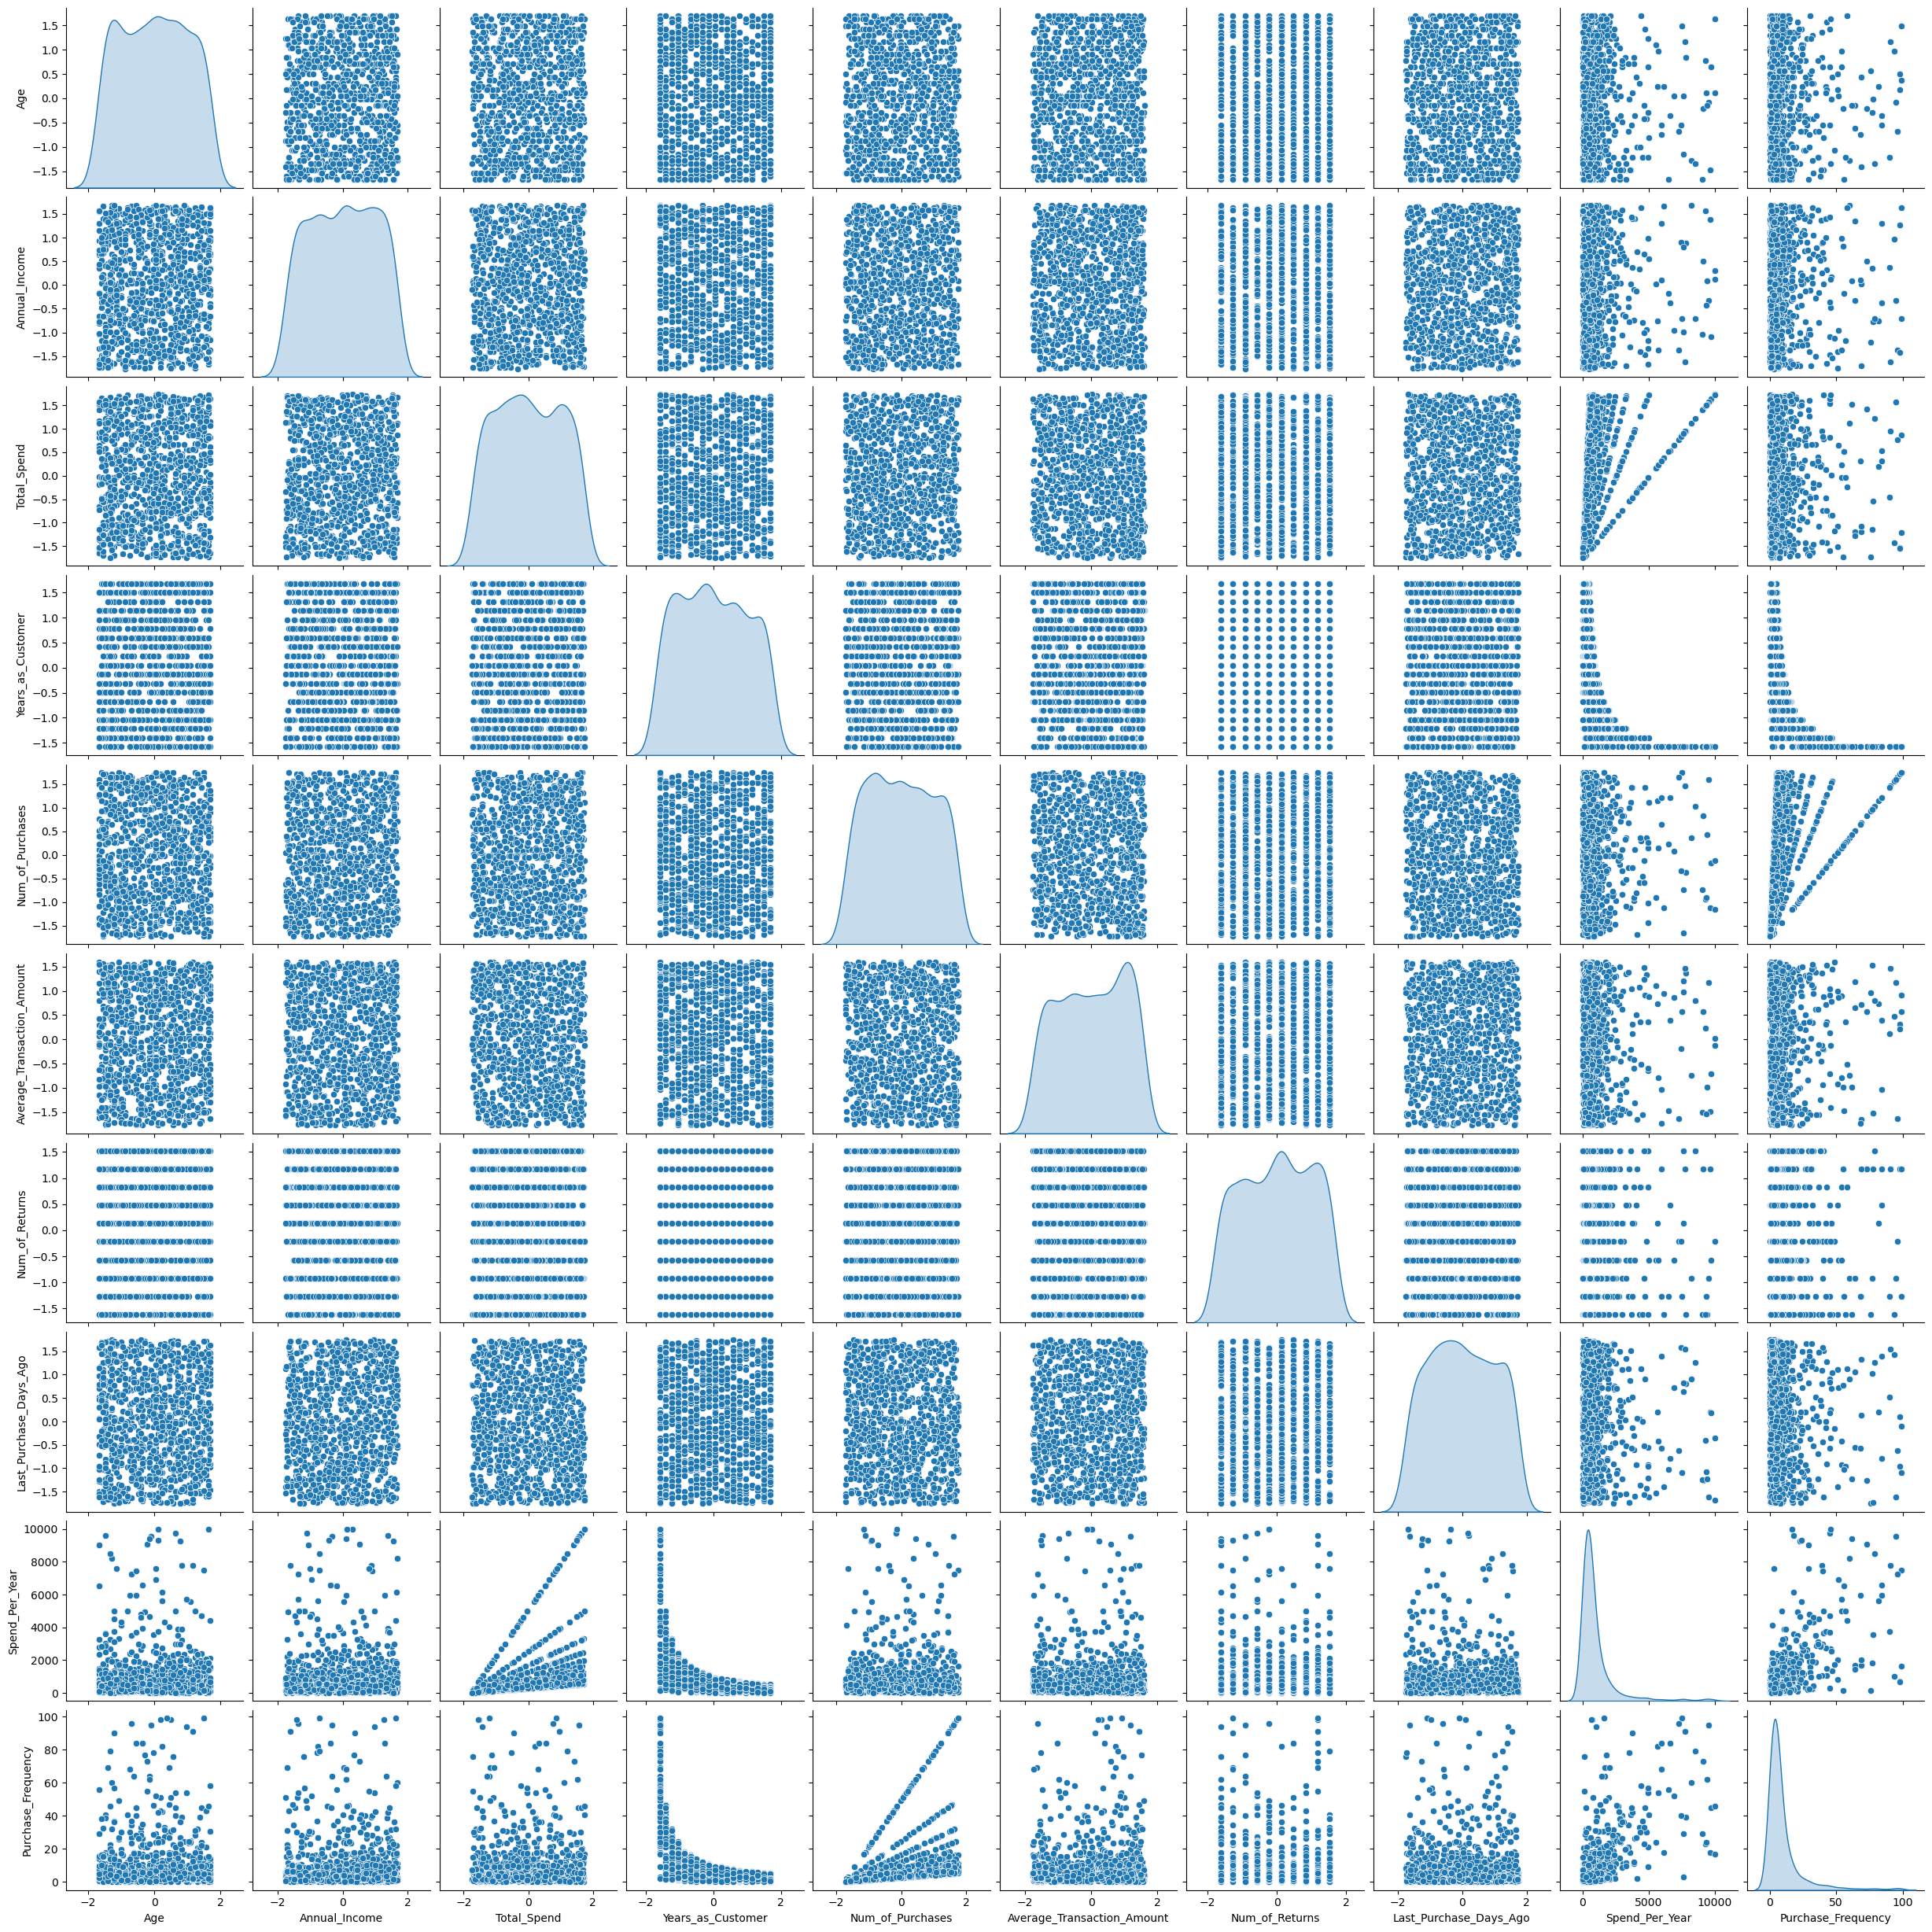

In [183]:
# Let's look at a pairplot of the numeric columns to see if we can spot any patterns.
import seaborn as sns
sns.pairplot(df, diag_kind='kde')
plt.show()

Looking at the pairplot, there are no strong correlations between the numeric columns. This is good, as it means we can use all of them in our analysis. It also means that we can eliminate clustering algorithms that work well with obvious clusters. This means that we will need to explore several specific clustering algorithms to see which works best, but once we find one that works well, we can be confident that it's the best choice for all future clustering we'll need to do on this dataset. 

Let's look at:
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
- Hierarchical Aggolmerative Clustering (HAC)
- Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)
- Mean Shift
- Gaussian Mixture Models (GMM)

#### Determining the Most Valuable Customers

We have `Total_Spend`, which is simply historical CLV. We could simply say that the top 20% of customers by CLV are our most valuable customers and leave it at that. Let's perform some clustering to see whether this assumption holds up. 

<Axes: title={'center': 'Annual Income vs. Total Spend'}, xlabel='Annual_Income', ylabel='Total_Spend'>

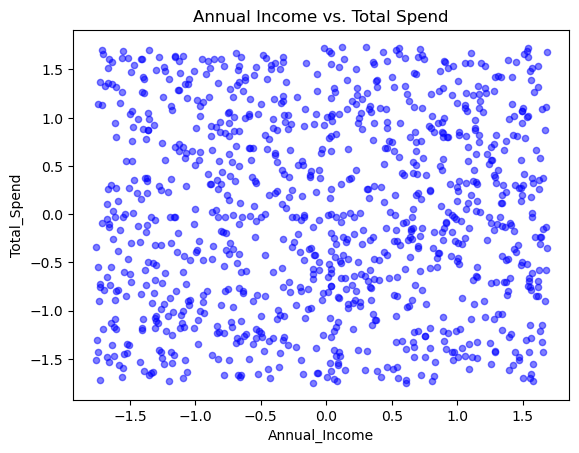

In [184]:
# The customers with the highest annual income and total spend are likely to be our most valuable customers, so let's learn more about them.
df.plot(kind="scatter", x="Annual_Income", y="Total_Spend", alpha=0.5, color="blue", title="Annual Income vs. Total Spend")

In [185]:
# Let's split the dataset into an X to simplify the clustering process.
X = pd.concat([df["Annual_Income"], df["Total_Spend"]], axis=1)

In [186]:
# Let's build a helper function to tune the hyperparameters of each model.
# Adapted from a hyperparameter tuning function in the book "Effective XGBoost", by Matt Harrison.
from sklearn.cluster import DBSCAN, HDBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from itertools import product

# Function to perform a grid search over DBSCAN parameters
def clustering_grid_search(X, algorithm, param_grid):
    # Initialize the best scores and parameters for each metric
    best_dbscore = np.inf  # Lower Davies-Bouldin Score is better
    best_silscore = -1    # Higher Silhouette Score is better
    best_chscore = -1     # Higher Calinski-Harabasz Score is better
    best_dbparams = best_silparams = best_chparams = None

    # Generate all combinations of parameters
    param_combinations = list(
        product(*(param_grid[name] for name in param_grid)))

    # Iterate over all combinations of parameters
    for params in param_combinations:
        # Unpack parameters
        kwargs = dict(zip(param_grid.keys(), params))

        # Initialize the clustering model based on the input algorithm
        if algorithm == 'DBSCAN':
            model = DBSCAN(**kwargs)
        elif algorithm == 'HAC':
            model = AgglomerativeClustering(**kwargs)
        elif algorithm == 'HDBSCAN':
            model = HDBSCAN(**kwargs)
        elif algorithm == 'MeanShift':
            model = MeanShift(**kwargs)
        elif algorithm == 'GMM':
            model = GaussianMixture(**kwargs)
        else:
            raise ValueError("Unsupported algorithm specified")

        # Fit the model and predict labels
        labels = model.fit_predict(X)

        # Calculate scores only if more than one cluster and not all noise
        if len(set(labels)) > 1 and not (len(set(labels)) == 2 and -1 in labels):
            try:
                silscore = silhouette_score(X, labels)
                if silscore > best_silscore:
                    best_silscore = silscore
                    best_silparams = kwargs
            except ValueError:
                pass  # Silhouette score cannot be calculated for a single cluster

            try:
                dbscore = davies_bouldin_score(X, labels)
                if dbscore < best_dbscore:
                    best_dbscore = dbscore
                    best_dbparams = kwargs
            except ValueError:
                pass

            try:
                chscore = calinski_harabasz_score(X, labels)
                if chscore > best_chscore:
                    best_chscore = chscore
                    best_chparams = kwargs
            except ValueError:
                pass

    print(
        f"Best params for Davies-Bouldin Score in {algorithm}: {best_dbparams}")
    print(f"Best Davies-Bouldin Score: {np.round(best_dbscore, 3)}")
    print(f"Best params for Silhouette Score in {algorithm}: {best_silparams}")
    print(f"Best Silhouette Score: {np.round(best_silscore, 3)}")
    print(
        f"Best params for Calinski-Harabasz Score in {algorithm}: {best_chparams}")
    print(f"Best Calinski-Harabasz Score: {np.round(best_chscore, 3)}")

param_grid_dbscan = {
    'eps': [0.170, 0.172, 0.1723, 0.1725, 0.175, 0.177, 0.185],
    'min_samples': [4, 5, 6, 7, 8, 9]
}
clustering_grid_search(X, 'DBSCAN', param_grid_dbscan)

Best params for Davies-Bouldin Score in DBSCAN: {'eps': 0.172, 'min_samples': 4}
Best Davies-Bouldin Score: 1.283
Best params for Silhouette Score in DBSCAN: {'eps': 0.175, 'min_samples': 9}
Best Silhouette Score: 0.101
Best params for Calinski-Harabasz Score in DBSCAN: {'eps': 0.175, 'min_samples': 8}
Best Calinski-Harabasz Score: 242.782


Cluster label with the highest total spend: 0


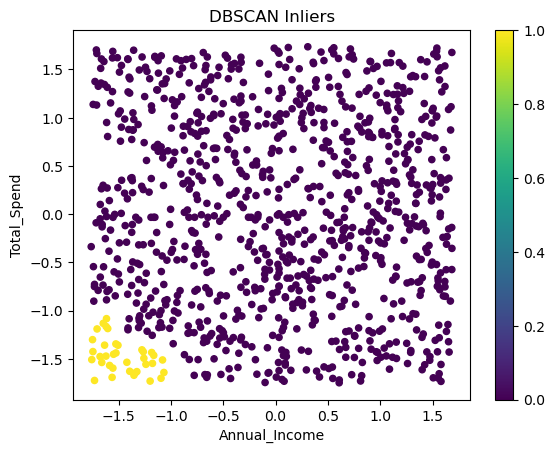

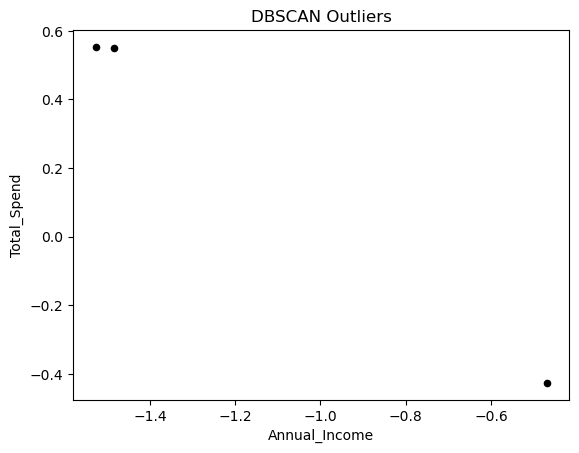

Davies-Bouldin_score: 1.2834293295200336
Silhouette_score: -0.04540529476042597
Calinski-Harabasz_score: 44.718048894102914


In [207]:
# Let's run DBSCAN based on our hyperparameter tuning results above.
dbscan = DBSCAN(eps=0.172, min_samples=4)
dbscan.fit(X)

# Get inliers and their cluster labels
X_inlier = X[dbscan.labels_ != -1]
y_inlier = dbscan.labels_[dbscan.labels_ != -1]

# Get outliers
X_outlier = X[dbscan.labels_ == -1]
X_inlier.plot.scatter(x="Annual_Income", y="Total_Spend", c=y_inlier, cmap='viridis', title="DBSCAN Inliers")
X_outlier.plot.scatter(x="Annual_Income", y="Total_Spend", color='k', title="DBSCAN Outliers")

# Find the cluster label with the highest Total_Spend
X_inlier_copy = X_inlier.copy().reset_index(drop=True)
print(f"Cluster label with the highest total spend: {
      y_inlier[X_inlier_copy['Total_Spend'].idxmax()]}")

# Visualize the clusters
plt.show()
print(f"Davies-Bouldin_score: {davies_bouldin_score(X, dbscan.labels_)}")
print(f"Silhouette_score: {silhouette_score(X, dbscan.labels_)}")
print(f"Calinski-Harabasz_score: {calinski_harabasz_score(X, dbscan.labels_)}")

In [188]:
# Let's see what the hyperparameter tuning function suggests for HAC.
param_grid_hac = {
    'n_clusters': [2, 3, 4, 5, 6],
    'linkage': ['ward', 'complete', 'average', 'single']
}
clustering_grid_search(X, 'HAC', param_grid_hac)

Best params for Davies-Bouldin Score in HAC: {'n_clusters': 4, 'linkage': 'complete'}
Best Davies-Bouldin Score: 0.818
Best params for Silhouette Score in HAC: {'n_clusters': 4, 'linkage': 'average'}
Best Silhouette Score: 0.358
Best params for Calinski-Harabasz Score in HAC: {'n_clusters': 5, 'linkage': 'ward'}
Best Calinski-Harabasz Score: 824.589


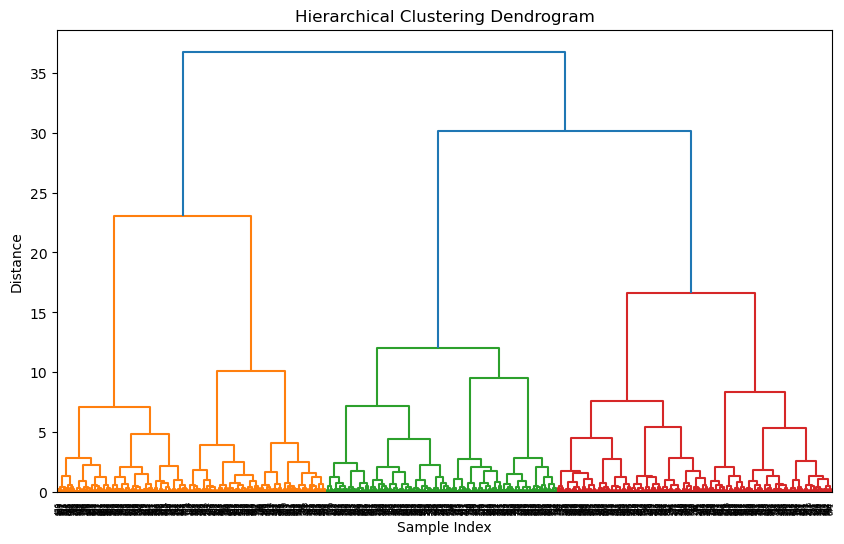

In [189]:
# Let's move on to HAC.
# Let's visualize a dendrogram of the data to get an idea of how many clusters we should aim for with HAC.
from scipy.cluster import hierarchy
Z = hierarchy.linkage(X, 'ward')

plt.figure(figsize=(10, 6))
hierarchy.dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

Cluster with the highest total spend: 2


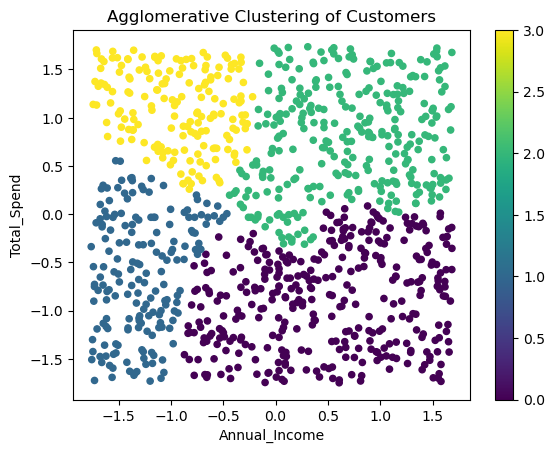

Davies-Bouldin_score: 0.858629419254443
Silhouette_score: 0.3488805404401585
Calinski-Harabasz_score: 771.5944619486479


In [190]:
# The two-cluster split is the most obvious one, but it's not particularly helpful for our question. Let's go one level deeper.
hac = AgglomerativeClustering(n_clusters=4, linkage="ward")
hac.fit(X)

X.plot.scatter(x="Annual_Income", y="Total_Spend", c=hac.labels_, cmap='viridis', title="Agglomerative Clustering of Customers")

# Find the cluster with the highest total spend
X_with_labels = X.copy()
X_with_labels['Cluster'] = hac.labels_
max_spend_index = X_with_labels['Total_Spend'].idxmax()
cluster_with_highest_spend = X_with_labels.loc[max_spend_index, 'Cluster']

print(f"Cluster with the highest total spend: {cluster_with_highest_spend}")

# Visualize the clusters
plt.show()
print(f"Davies-Bouldin_score: {davies_bouldin_score(X, hac.labels_)}")
print(f"Silhouette_score: {silhouette_score(X, hac.labels_)}")
print(f"Calinski-Harabasz_score: {calinski_harabasz_score(X, hac.labels_)}")

In [191]:
# Let's move on to HDBSCAN.
param_grid_hdbscan = {'min_cluster_size': [2, 3, 4, 5, 6, 12, 24, 48, 72, 100], 'cluster_selection_epsilon': [0, 0.15, 0.2, 0.25, 0.5, 3, 5, 7]}
clustering_grid_search(X, 'HDBSCAN', param_grid_hdbscan)

Best params for Davies-Bouldin Score in HDBSCAN: {'min_cluster_size': 2, 'cluster_selection_epsilon': 0.2}
Best Davies-Bouldin Score: 0.837
Best params for Silhouette Score in HDBSCAN: {'min_cluster_size': 2, 'cluster_selection_epsilon': 0}
Best Silhouette Score: 0.302
Best params for Calinski-Harabasz Score in HDBSCAN: {'min_cluster_size': 6, 'cluster_selection_epsilon': 0.15}
Best Calinski-Harabasz Score: 78.552


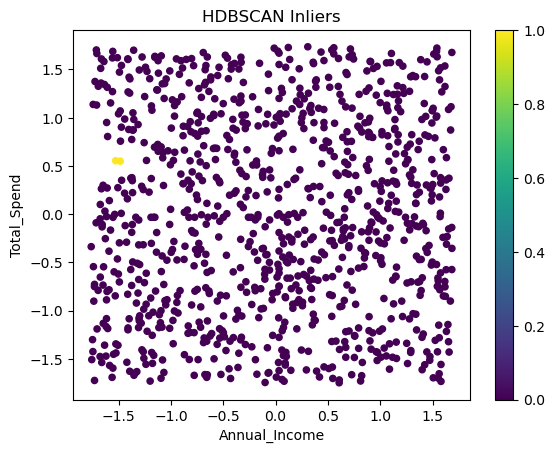

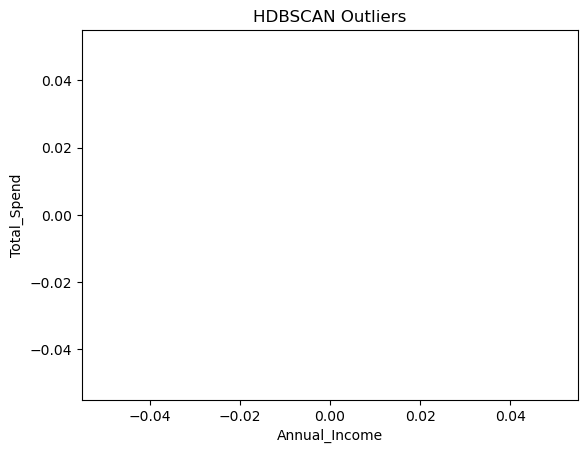

Davies-Bouldin_score: 0.8367310519177157
Silhouette_score: 0.021920635378048857
Calinski-Harabasz_score: 2.5770377701550955


In [192]:
# Let's try HDBSCAN next.
from sklearn.cluster import HDBSCAN
hdb = HDBSCAN(min_cluster_size=2, cluster_selection_epsilon=0.2)
hdb.fit(X)

# Get inliers and their cluster labels
X_inlier = X[hdb.labels_ != -1]
y_inlier = hdb.labels_[hdb.labels_ != -1]

# Get outliers
X_outlier = X[hdb.labels_ == -1]
X_inlier.plot.scatter(x="Annual_Income", y="Total_Spend",
                      c=y_inlier, cmap='viridis', title="HDBSCAN Inliers")
X_outlier.plot.scatter(x="Annual_Income", y="Total_Spend",
                       color='k', title="HDBSCAN Outliers")
plt.show()
print(f"Davies-Bouldin_score: {davies_bouldin_score(X, hdb.labels_)}")
print(f"Silhouette_score: {silhouette_score(X, hdb.labels_)}")
print(f"Calinski-Harabasz_score: {calinski_harabasz_score(X, hdb.labels_)}")

In [193]:
# Let's try mean shift next. Before we try hyperparameter tuning, let's estimate the bandwidth.
bandwidth = estimate_bandwidth(X, quantile=0.2)
print(bandwidth)

1.0398745163055494


In [194]:

param_grid_meanshift = {'bandwidth': [1, bandwidth, 1.05, 1.06, 1.07, 1.1]}
clustering_grid_search(X, 'MeanShift', param_grid_meanshift)

Best params for Davies-Bouldin Score in MeanShift: {'bandwidth': 1.07}
Best Davies-Bouldin Score: 0.853
Best params for Silhouette Score in MeanShift: {'bandwidth': 1.07}
Best Silhouette Score: 0.382
Best params for Calinski-Harabasz Score in MeanShift: {'bandwidth': 1.07}
Best Calinski-Harabasz Score: 780.291


Davies-Bouldin_score: 0.8530541892351898
Silhouette_score: 0.38115236032889627
Calinski_Harabasz_score: 777.4372671345598


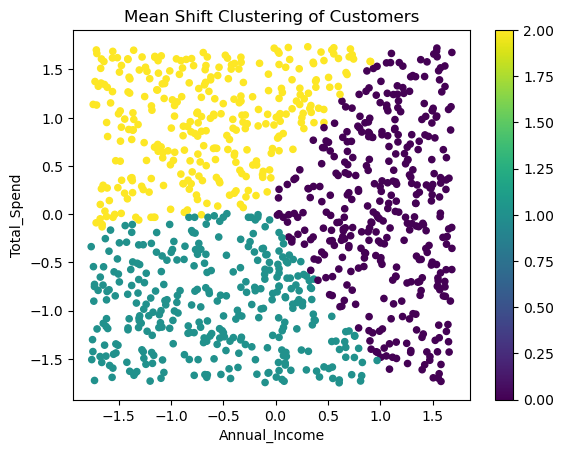

In [195]:
ms = MeanShift(bandwidth=1.06)
ms.fit(X)
labels = ms.labels_

X.plot.scatter(x="Annual_Income", y="Total_Spend", c=ms.labels_,
               cmap='viridis', title="Mean Shift Clustering of Customers")

# Find the cluster with the highest total spend
X_with_labels = X.copy()
X_with_labels['Cluster'] = ms.labels_
max_spend_index = X_with_labels['Total_Spend'].idxmax()
cluster_with_highest_spend = X_with_labels.loc[max_spend_index, 'Cluster']

print(f"Davies-Bouldin_score: {davies_bouldin_score(X, ms.labels_)}")
print(f"Silhouette_score: {silhouette_score(X, ms.labels_)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(X, ms.labels_)}")

In [196]:
# Finally, let's try GMM.
param_grid_gmm = {
    'n_components': [5, 6, 7, 8, 10, 15, 20],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'k-means++', 'random']
}
clustering_grid_search(X, 'GMM', param_grid_gmm)

Best params for Davies-Bouldin Score in GMM: {'n_components': 20, 'covariance_type': 'spherical', 'init_params': 'k-means++'}
Best Davies-Bouldin Score: 0.755
Best params for Silhouette Score in GMM: {'n_components': 5, 'covariance_type': 'tied', 'init_params': 'kmeans'}
Best Silhouette Score: 0.382
Best params for Calinski-Harabasz Score in GMM: {'n_components': 20, 'covariance_type': 'tied', 'init_params': 'kmeans'}
Best Calinski-Harabasz Score: 1013.445


Davies-Bouldin_score: 0.8195438800026609
Silhouette_score: 0.36728148479269634
Calinski_Harabasz_score: 934.0756057406232


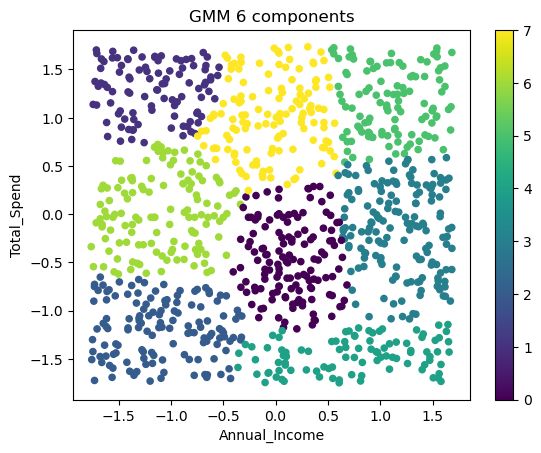

In [197]:
gmm = GaussianMixture(n_components=8, covariance_type='diag',
                        init_params='kmeans', random_state=42)
gmm.fit(X)

labels = gmm.fit_predict(X)
X.plot.scatter(x="Annual_Income", y="Total_Spend", c=labels,
                   cmap='viridis', colorbar=True, title=f"GMM 6 components")

X_gmm = X.copy()
X_gmm["Cluster"] = labels
max_spend_index = X_gmm['Total_Spend'].idxmax()

print(f"Davies-Bouldin_score: {davies_bouldin_score(X, labels)}")
print(f"Silhouette_score: {silhouette_score(X, labels)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(X, labels)}")

The wisdom of the crowds says that customers with a CLV greater than $8000-8500 are the most valuable customers. Because most of these clusters have varying sizes and densities, let's compare scores (prioritizing Davies-Bouldin) to determine the best clustering algorithm for this dataset, as well as have a go-to algorithm in case we need to do more clustering on similar data within the top cluster.

| Algorithm | Davies-Bouldin Score | Silhouette Score | Calinski-Harabasz Score |
|-----------|----------------------|------------------|-------------------------|    
| DBSCAN    | 0.000                | 0.000            | 000.000                 |
| HAC       | 0.000                | 0.000            | 000.000                 |
| HDBSCAN   | 0.000                | 0.000            | 000.000                 |
| Mean Shift| 0.000                | 0.000            | 000.000                 |
| GMM       | 0.798                | 0.367            | 958.573                 |

I wouldn't expect the Silhouette Score to be the best metric for this dataset, as the clusters are not well-defined. The Davies-Bouldin Score is the best metric for this dataset, as it's the most robust to varying cluster sizes and densities. The Calinski-Harabasz Score is also a good metric, as it's the most robust to varying cluster sizes and densities. DBSCAN has the best Davies-Bouldin Score, but its Calinski-Harabasz score is quite bad. GMM has the best tradeoff between Davies-Bouldin and Calinski-Harabasz scores, so it's a good benchmark for future subsets of this dataset.

In [198]:
# Create a new DataFrame of the most valuable customers based on the GMM clustering
mvc_clv = df.loc[X_gmm["Cluster"] == 4]
mvc_clv.head()

Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
Customer_ID                                                                    
6            0.899981    Male       1.505265    -1.696333           1.682163   
19           0.899981    Male       0.576084    -1.315959           0.956780   
52          -1.011786   Other       0.059362    -1.408495          -0.131294   
64           0.965904   Other       0.606751    -1.747828           0.231397   
86          -0.352556  Female       0.912069    -1.399590           1.682163   

             Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
Customer_ID                                                                 
6                    1.247668                    1.037797        0.127626   
19                  -1.259391                   -0.646310        0.825034   
52                  -0.411935                   -0.098251       -0.221079   
64                  -1.294702                    0.564013       -1.615896   
86                  -0.482556                    0.400223        1.173739   

             Last_Purchase_Days_Ago  Spend_Per_Year  Purchase_Frequency  
Customer_ID                                                              
6                         -0.509309       13.431053            4.473684  
19                        -1.724613          89.032            0.933333  
52                        -0.142789      119.185556            4.222222  
64                        -1.136251        9.903636            1.181818  
86                         0.426282       57.787368            1.894737

In [199]:
mvc_clv.describe(include="all")

Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count   95.000000     95      95.000000    95.000000          95.000000   
unique        NaN      3            NaN          NaN                NaN   
top           NaN   Male            NaN          NaN                NaN   
freq          NaN     35            NaN          NaN                NaN   
mean     0.036043    NaN       0.740406    -1.459068          -0.201924   
std      1.021749    NaN       0.587100     0.167762           1.093941   
min     -1.671017    NaN      -0.359613    -1.747828          -1.582060   
25%     -0.912902    NaN       0.123952    -1.603339          -1.219369   
50%      0.174828    NaN       0.755864    -1.441582          -0.312640   
75%      0.867020    NaN       1.255720    -1.321876           0.684761   
max      1.691057    NaN       1.656487    -1.144153           1.682163   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count          95.000000                   95.000000       95.000000   
unique               NaN                         NaN             NaN   
top                  NaN                         NaN             NaN   
freq                 NaN                         NaN             NaN   
mean           -0.007534                    0.269411       -0.011856   
std             1.002922                    0.923050        0.957536   
min            -1.683119                   -1.655325       -1.615896   
25%            -0.782697                   -0.390418       -0.918487   
50%            -0.058828                    0.400223        0.127626   
75%             0.682697                    1.090762        0.825034   
max             1.742018                    1.563443        1.522443   

        Last_Purchase_Days_Ago  Spend_Per_Year  Purchase_Frequency  
count                95.000000            95.0                95.0  
unique                     NaN            <NA>                <NA>  
top                        NaN            <NA>                <NA>  
freq                       NaN            <NA>                <NA>  
mean                 -0.016689       253.96734           13.404789  
std                   1.011337      353.227617            19.42148  
min                  -1.724613        9.903636            0.111111  
25%                  -0.909587       62.401706            3.035714  
50%                  -0.027045      119.185556                 5.7  
75%                   0.783157      246.938333              14.875  
max                   1.689813         1823.42                99.0

In [200]:
# It looks like there are a few outliers in the Total_Spend column of the mvc DataFrame. Let's remove them.
mvc_clv = mvc_clv[mvc_clv["Total_Spend"] > 8000]

In [201]:
# The higher count of Female in "Gender" is interesting. Let's look at the distribution.
mvc_clv["Gender"].value_counts()

Series([], Name: count, dtype: Int64)

In [202]:
mvc_clv.describe(include="all")

Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count   0.0      0            0.0          0.0                0.0   
unique  NaN      0            NaN          NaN                NaN   
top     NaN    NaN            NaN          NaN                NaN   
freq    NaN    NaN            NaN          NaN                NaN   
mean    NaN    NaN            NaN          NaN                NaN   
std     NaN    NaN            NaN          NaN                NaN   
min     NaN    NaN            NaN          NaN                NaN   
25%     NaN    NaN            NaN          NaN                NaN   
50%     NaN    NaN            NaN          NaN                NaN   
75%     NaN    NaN            NaN          NaN                NaN   
max     NaN    NaN            NaN          NaN                NaN   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count                0.0                         0.0             0.0   
unique               NaN                         NaN             NaN   
top                  NaN                         NaN             NaN   
freq                 NaN                         NaN             NaN   
mean                 NaN                         NaN             NaN   
std                  NaN                         NaN             NaN   
min                  NaN                         NaN             NaN   
25%                  NaN                         NaN             NaN   
50%                  NaN                         NaN             NaN   
75%                  NaN                         NaN             NaN   
max                  NaN                         NaN             NaN   

        Last_Purchase_Days_Ago  Spend_Per_Year  Purchase_Frequency  
count                      0.0             0.0                 0.0  
unique                     NaN            <NA>                <NA>  
top                        NaN            <NA>                <NA>  
freq                       NaN            <NA>                <NA>  
mean                       NaN            <NA>                <NA>  
std                        NaN            <NA>                <NA>  
min                        NaN            <NA>                <NA>  
25%                        NaN            <NA>                <NA>  
50%                        NaN            <NA>                <NA>  
75%                        NaN            <NA>                <NA>  
max                        NaN            <NA>                <NA>

The median most-valuable customer is 44 years old and has an annual income of $100,000. They have been a customer for nine years. They have made 53 purchases with an average transaction amount of $266.48. They make a purchase every 68 days.

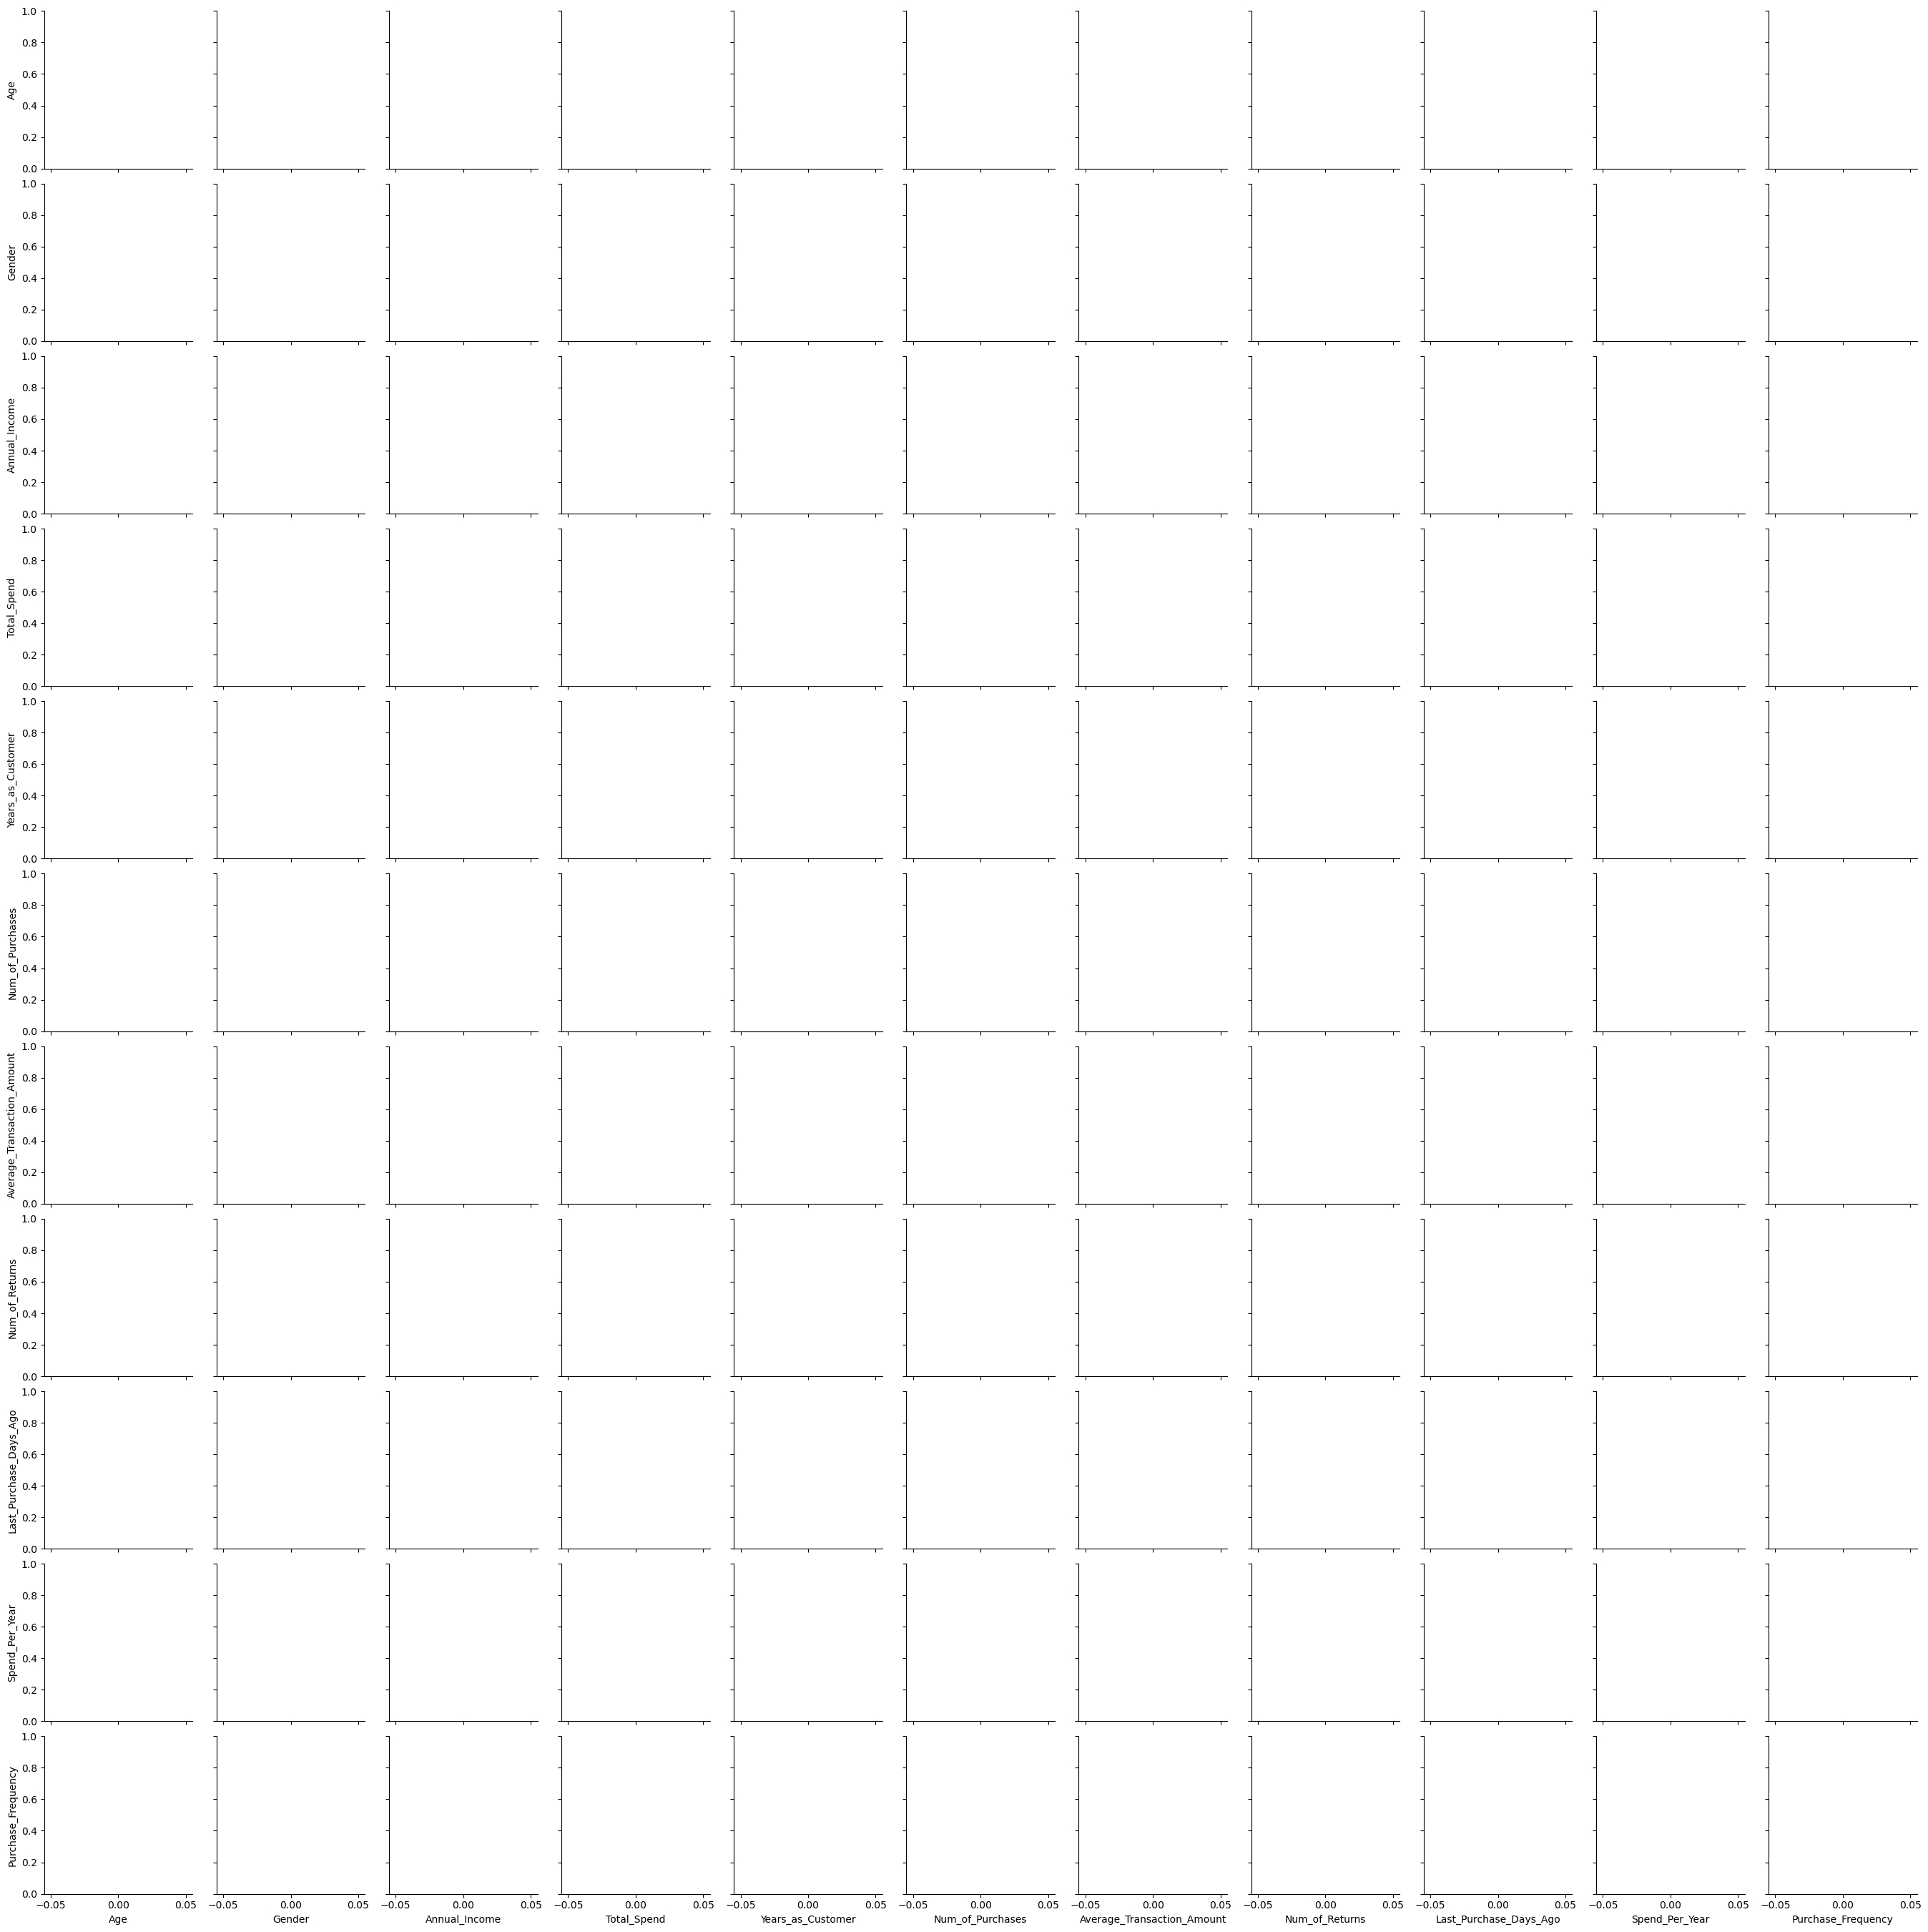

In [203]:
# Let's plot the pairplot to look for any interesting, obvious trends.
sns.pairplot(mvc_clv, diag_kind='kde')
plt.show()

Most of the interesting, obvious trends are in the `Spend_Per_Year` and `Purchase Frequency` columns, which are the average amount each customer spent per year, and the number of purchases each customer made per year. The longer a customer has been with the company, the less they spend per year and the less frequently they make purchases.

Let's move up a dimension:
- Who spends the most? Total Spend vs. Average Transaction Amount vs. Spend Per Year
- Who is the most loyal? Last Purchase Days Ago vs. Years as a Customer vs. Number of Purchases
- Who has the highest growth potential? Total Spend vs. Purchase Frequency vs. Number of Purchases
- Who is the most profitable? Total Spend vs. Num of Purchases vs. Average Transaction Amount

We can also look at:
- Total Spend vs. Years as a Customer (the most loyal customers: maybe introduce a loyalty program to slow the spend decline?)
- Spend Per Year vs. Purchase Frequency

In [204]:
big_spenders = pd.concat([mvc_clv["Total_Spend"], mvc_clv["Average_Transaction_Amount"], mvc_clv["Spend_Per_Year"]], axis=1)

In [205]:
# Plot the big_spenders DataFrame as a 3D scatter plot
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=big_spenders["Total_Spend"],
    y=big_spenders["Average_Transaction_Amount"],
    z=big_spenders["Spend_Per_Year"],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title="Total Spend",
        yaxis_title="Average Transaction Amount",
        zaxis_title="Spend Per Year"
    )
)

In [206]:
param_grid_dbscan = {
    'eps': [180, 190, 200, 210, 220, 230, 240],
    'min_samples': [2, 3, 4, 5, 10, 15]
}
clustering_grid_search(big_spenders, 'DBSCAN', param_grid_dbscan)

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by DBSCAN.

In [ ]:
param_grid_hac = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'linkage': ['ward', 'complete', 'average', 'single']
}
clustering_grid_search(big_spenders, 'HAC', param_grid_hac)

# Not bad.

Best params for Davies-Bouldin Score in HAC: {'n_clusters': 2, 'linkage': 'ward'}
Best Davies-Bouldin Score: 0.162
Best params for Silhouette Score in HAC: {'n_clusters': 2, 'linkage': 'ward'}
Best Silhouette Score: 0.85
Best params for Calinski-Harabasz Score in HAC: {'n_clusters': 11, 'linkage': 'ward'}
Best Calinski-Harabasz Score: 867.069


In [ ]:
param_grid_hdbscan = {'min_cluster_size': [2, 3, 4, 5, 6], 'cluster_selection_epsilon': [0, 3, 5, 7]}
clustering_grid_search(big_spenders, 'HDBSCAN', param_grid_hdbscan)

Best params for Davies-Bouldin Score in HDBSCAN: {'min_cluster_size': 6, 'cluster_selection_epsilon': 0}
Best Davies-Bouldin Score: 0.162
Best params for Silhouette Score in HDBSCAN: {'min_cluster_size': 6, 'cluster_selection_epsilon': 0}
Best Silhouette Score: 0.85
Best params for Calinski-Harabasz Score in HDBSCAN: {'min_cluster_size': 6, 'cluster_selection_epsilon': 0}
Best Calinski-Harabasz Score: 648.843


In [ ]:
# Mean Shift uses the estimate_parameters method to estimate the bandwidth by default. Let's use that rather than extensive tuning.
clustering_grid_search(big_spenders, 'MeanShift', param_grid_meanshift)

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by MeanShift.

In [ ]:
param_grid_gmm = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'k-means++', 'random']
}
clustering_grid_search(big_spenders, 'GMM', param_grid_gmm)

Best params for Davies-Bouldin Score in GMM: {'n_components': 2, 'covariance_type': 'full', 'init_params': 'kmeans'}
Best Davies-Bouldin Score: 0.162
Best params for Silhouette Score in GMM: {'n_components': 2, 'covariance_type': 'full', 'init_params': 'kmeans'}
Best Silhouette Score: 0.85
Best params for Calinski-Harabasz Score in GMM: {'n_components': 5, 'covariance_type': 'spherical', 'init_params': 'kmeans'}
Best Calinski-Harabasz Score: 958.03


In [ ]:
# None of these results are great, but it looks like GMM is the best choice for this dataset. Let's run it.
gmm = GaussianMixture(n_components=5, covariance_type='spherical',
                        init_params='kmeans', random_state=42)
gmm.fit(big_spenders)
labels = gmm.fit_predict(big_spenders)

print(f"Silhouette_score: {silhouette_score(big_spenders, labels)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(big_spenders, labels)}")

fig = go.Figure(data=[go.Scatter3d(
    x=big_spenders["Total_Spend"],
    y=big_spenders["Average_Transaction_Amount"],
    z=big_spenders["Spend_Per_Year"],
    mode='markers',
    marker=dict(
        size=5,
        color=labels,
        opacity=0.8,
        colorscale='Viridis',
        colorbar=dict(title='Cluster Labels')
    ),
    text=[f"Cluster: {label}" for label in labels],
    hoverinfo='text'
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title="Total Spend",
        yaxis_title="Average Transaction Amount",
        zaxis_title="Spend Per Year"
    )
)

Silhouette_score: 0.4438424687414835
Calinski_Harabasz_score: 935.5085194527959


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': array([3, 0, 4, 0, 3, 4, 4, 3, 2, 3, 4, 3, 4, 4, 4, 3, 2, 3, 1, 4, 3, 0, 0, 1,
                                         3, 3, 4, 3, 0, 2, 3, 0, 0, 3, 4, 3, 0, 4, 3, 4, 1, 3, 4, 3, 0, 4, 3, 4,
                                         0, 0, 4, 3, 3, 4, 3, 4, 0, 1, 2, 2, 4, 0, 4, 4, 0, 4, 4, 4, 3, 3, 1, 3,
                                         3, 3, 3, 2, 3, 4, 3, 0, 4, 4, 1, 3, 3, 0, 4, 4, 3, 3, 4, 0, 4, 4, 4, 3,
                                         4, 4, 3, 0, 3, 4, 4, 3, 3, 3, 3, 1, 4, 3, 4, 3, 4, 0, 3, 3, 4, 3, 3, 3,
                                         4, 1, 4, 3, 3, 0, 4, 3, 1, 3, 4, 3, 1, 4, 3, 2, 3, 4, 4, 4, 1, 4, 0, 3,
                                         4, 4, 0, 4, 4, 3]),
                         'colorbar': {'title': {'text': 'Cluster Labels'}},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888888,
                                        '#b5de2b'], [1.0, '#fde725']],
                         'opacity': 0.8,
                         'size': 5},
              'mode': 'markers',
              'text': [Cluster: 3, Cluster: 0, Cluster: 4, Cluster: 0, Cluster: 3,
                       Cluster: 4, Cluster: 4, Cluster: 3, Cluster: 2, Cluster: 3,
                       Cluster: 4, Cluster: 3, Cluster: 4, Cluster: 4, Cluster: 4,
                       Cluster: 3, Cluster: 2, Cluster: 3, Cluster: 1, Cluster: 4,
                       Cluster: 3, Cluster: 0, Cluster: 0, Cluster: 1, Cluster: 3,
                       Cluster: 3, Cluster: 4, Cluster: 3, Cluster: 0, Cluster: 2,
                       Cluster: 3, Cluster: 0, Cluster: 0, Cluster: 3, Cluster: 4,
                       Cluster: 3, Cluster: 0, Cluster: 4, Cluster: 3, Cluster: 4,
                       Cluster: 1, Cluster: 3, Cluster: 4, Cluster: 3, Cluster: 0,
                       Cluster: 4, Cluster: 3, Cluster: 4, Cluster: 0, Cluster: 0,
                       Cluster: 4, Cluster: 3, Cluster: 3, Cluster: 4, Cluster: 3,
                       Cluster: 4, Cluster: 0, Cluster: 1, Cluster: 2, Cluster: 2,
                       Cluster: 4, Cluster: 0, Cluster: 4, Cluster: 4, Cluster: 0,
                       Cluster: 4, Cluster: 4, Cluster: 4, Cluster: 3, Cluster: 3,
                       Cluster: 1, Cluster: 3, Cluster: 3, Cluster: 3, Cluster: 3,
                       Cluster: 2, Cluster: 3, Cluster: 4, Cluster: 3, Cluster: 0,
                       Cluster: 4, Cluster: 4, Cluster: 1, Cluster: 3, Cluster: 3,
                       Cluster: 0, Cluster: 4, Cluster: 4, Cluster: 3, Cluster: 3,
                       Cluster: 4, Cluster: 0, Cluster: 4, Cluster: 4, Cluster: 4,
                       Cluster: 3, Cluster: 4, Cluster: 4, Cluster: 3, Cluster: 0,
                       Cluster: 3, Cluster: 4, Cluster: 4, Cluster: 3, Cluster: 3,
                       Cluster: 3, Cluster: 3, Cluster: 1, Cluster: 4, Cluster: 3,
                       Cluster: 4, Cluster: 3, Cluster: 4, Cluster: 0, Cluster: 3,
                       Cluster: 3, Cluster: 4, Cluster: 3, Cluster: 3, Cluster: 3,
                       Cluster: 4, Cluster: 1, Cluster: 4, Cluster: 3, Cluster: 3,
                       Cluster: 0, Cluster: 4, Cluster: 3, Cluster: 1, Cluster: 3,
                       Cluster: 4, Cluster: 3, Cluster: 1, Cluster: 4, Cluster: 3,
                       Cluster: 2, Cluster: 3, Cluster: 4, Cluster: 4, Cluster: 4,
                       Cluster: 1, Cluster: 4

It looks like the average transaction amount isn't as important a factor here as the relationship between total spend and spend per year. It is difficult to tell whether this is a function of pricing promotion reponsiveness or of other variables not visualized here, like customer lifetime.

Cluster 0 is a segment of customers with varying total spend and average transaction amount, but low spend per year. These may be non-regular or opportunistic customers. This segment may respond best to promotions and seasonal sales. We may consider targeting them with promotions around holidays or events that are likely to drive sales, but otherwise not invest too much in them.

Cluster 1 is a segment of customers who have spent a high spend per year, high total spend, but varying amounts of average transaction amount. These customers may be purchasing a wide variety of products. They could represent a constant revenue stream, since they may be adaptable in the face of potential inventory shortages of certain products. This segment would be a good target for cross-selling complementary items and upselling premium versions products they would like to purchase. 

Cluster 2 is a segment of customers with high total spend, varying transaction amounts, and moderate spend per year. These may be seasonal or promotional customers. This is a fairly small segment, so improvements to seasonal promotions or targeted marketing campaigns aimed at other segments may be more effective than specifically trying to retain these customers.

Cluster 3 is a segment of customers with relatively low- to moderate total spend, low spend per year, and varying transaction amounts. Their spending may be event-driven, like buying replacements or upgrades for gear. This segment would be a good target for marketing campaigns around seasonal events or product launches. This segment is prime for re-engagement campaigns, as they may have lapsed in their purchasing.

Moving forward, **we would most likely want to focus on the customers in Cluster 1**, as they represent the most consistent revenue stream. We could offer exclusive promotions, loyalty benefits, VIP treatment, and the opportunity to build a community. **We would also want to focus on the customers in Cluster 3**, as they represent the most potential for growth through re-engagement. We would want to focus on the customers in Cluster 0 and Cluster 2 the least, as they represent the least consistent revenue streams and the least potential for growth: we should consider them during promotions and seasonal sales, but not invest too much in them otherwise.